# Predict Material Property

## By Josh Thyng


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Loading the Data


In [36]:
df = pd.read_csv("concrete_data.csv")
df.columns = df.columns.str.strip()

df.rename(
    columns={
        "Cement (component 1)(kg in a m^3 mixture)": "cement",
        "Blast Furnace Slag (component 2)(kg in a m^3 mixture)": "slag",
        "Fly Ash (component 3)(kg in a m^3 mixture)": "fly_ash",
        "Water  (component 4)(kg in a m^3 mixture)": "water",
        "Superplasticizer (component 5)(kg in a m^3 mixture)": "superplasticizer",
        "Coarse Aggregate  (component 6)(kg in a m^3 mixture)": "coarse_aggregate",
        "Fine Aggregate (component 7)(kg in a m^3 mixture)": "fine_aggregate",
        "Age (day)": "age",
        "Concrete compressive strength(MPa, megapascals)": "compressive_strength",
    },
    inplace=True,
)

print(df.head())
print(df.info())
print(df.describe())

   cement   slag  fly_ash  water  superplasticizer  coarse_aggregate  \
0   540.0    0.0      0.0  162.0               2.5            1040.0   
1   540.0    0.0      0.0  162.0               2.5            1055.0   
2   332.5  142.5      0.0  228.0               0.0             932.0   
3   332.5  142.5      0.0  228.0               0.0             932.0   
4   198.6  132.4      0.0  192.0               0.0             978.4   

   fine_aggregate  age  compressive_strength  
0           676.0   28             79.986111  
1           676.0   28             61.887366  
2           594.0  270             40.269535  
3           594.0  365             41.052780  
4           825.5  360             44.296075  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   slag                 

### EDA to Understand the Data


In [37]:
print(df.isnull().sum())

cement                  0
slag                    0
fly_ash                 0
water                   0
superplasticizer        0
coarse_aggregate        0
fine_aggregate          0
age                     0
compressive_strength    0
dtype: int64


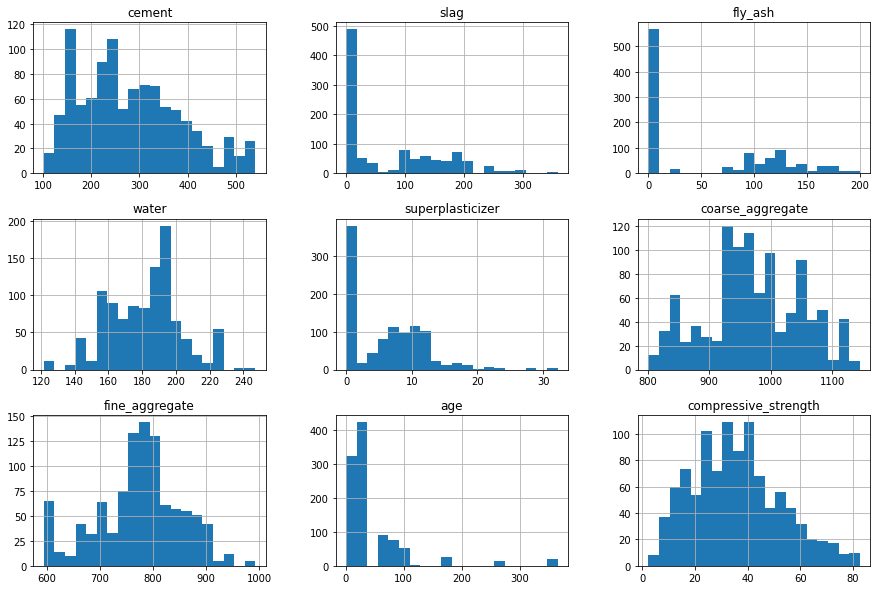

In [38]:
df.hist(bins=20, figsize=(15, 10))
plt.show()

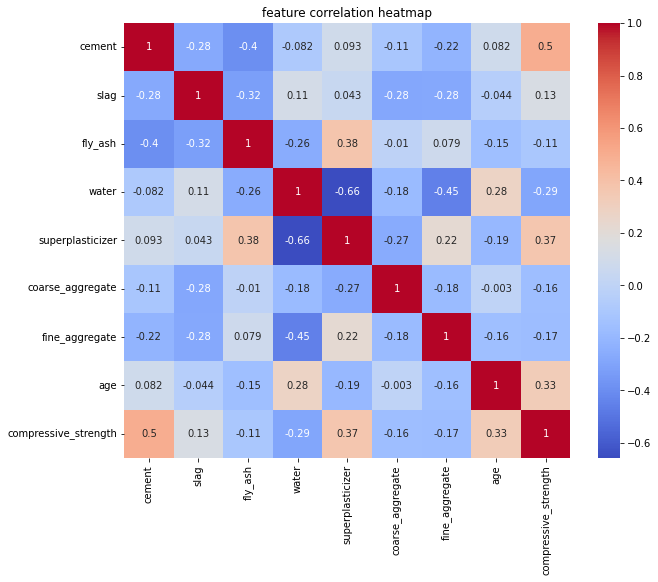

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("feature correlation heatmap")
plt.show()

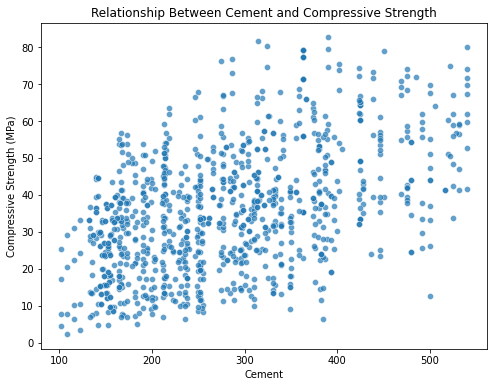

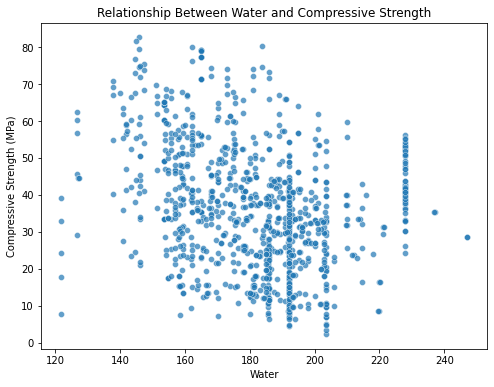

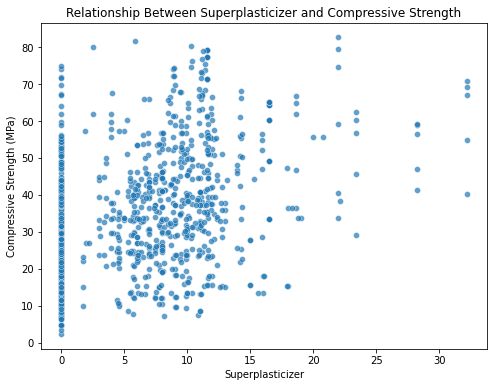

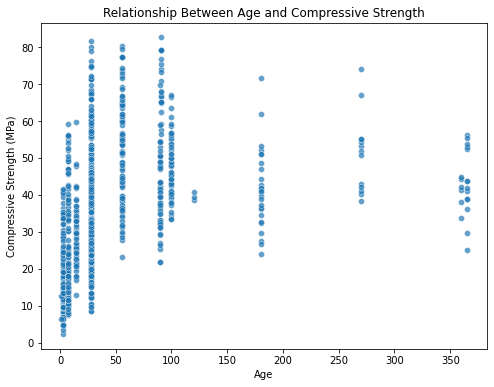

In [40]:
key_features = ["cement", "water", "superplasticizer", "age"]

for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[feature], y=df["compressive_strength"], alpha=0.7)
    plt.title(f"Relationship Between {feature.capitalize()} and Compressive Strength")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Compressive Strength (MPa)")
    plt.show()

C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


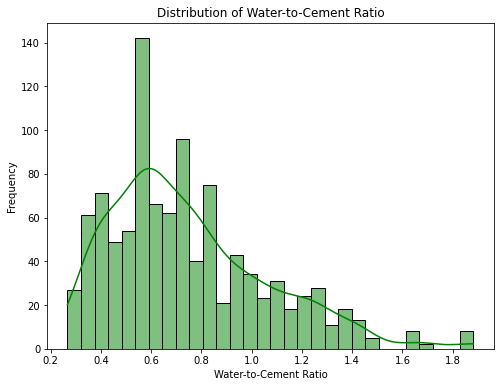

In [41]:
df["water_to_cement_ratio"] = df["water"] / df["cement"]
plt.figure(figsize=(8, 6))
sns.histplot(df["water_to_cement_ratio"], kde=True, bins=30, color="green")
plt.title("Distribution of Water-to-Cement Ratio")
plt.xlabel("Water-to-Cement Ratio")
plt.ylabel("Frequency")
plt.show()

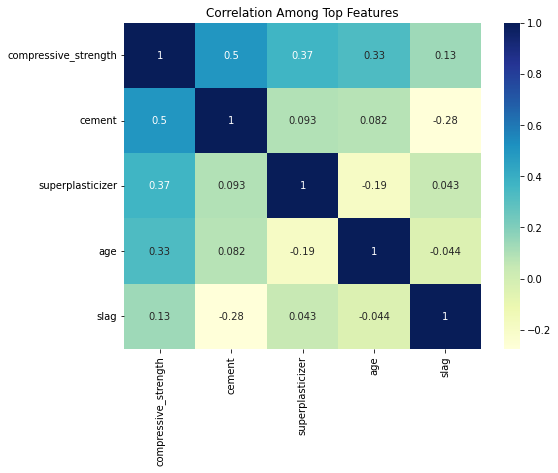

In [42]:
top_corr_features = (
    df.corr()["compressive_strength"].sort_values(ascending=False).head(5).index
)
plt.figure(figsize=(8, 6))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Among Top Features")
plt.show()

### Data Preprocessing


C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


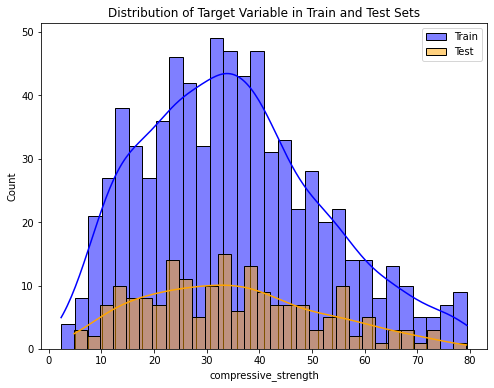

In [43]:
target_column = "compressive_strength"

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

for feature in df.columns[:-1]:
    df = remove_outliers(df, feature)

df["water_to_cement_ratio"] = df["water"] / df["cement"]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop([target_column], axis=1))
scaled_data = pd.DataFrame(scaled_features, columns=df.columns[:-1])
scaled_data[target_column] = df[target_column].reset_index(drop=True)


def stratified_split(X, y, test_size=0.2, random_state=42):
    y_binned, bins = pd.qcut(y, q=10, retbins=True, duplicates="drop")
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y_binned
    )

X = scaled_data.drop(target_column, axis=1)
y = scaled_data[target_column]

X_train, X_test, y_train, y_test = stratified_split(X, y)

plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True, bins=30, color="blue", label="Train")
sns.histplot(y_test, kde=True, bins=30, color="orange", label="Test")
plt.title("Distribution of Target Variable in Train and Test Sets")
plt.legend()
plt.show()

### Feature Engineering


Index(['cement', 'slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'compressive_strength',
       'water_to_cement_ratio', 'aggregate_ratio', 'cementitious_material',
       'age_log'],
      dtype='object')


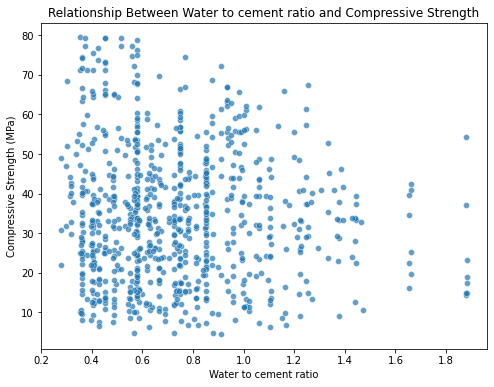

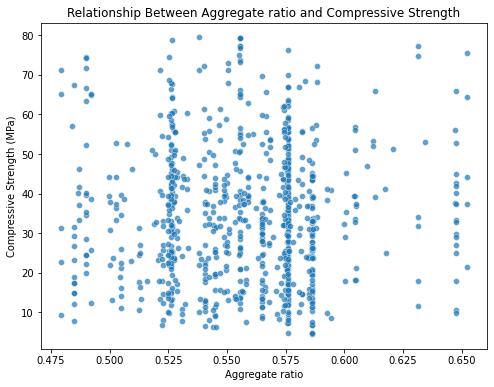

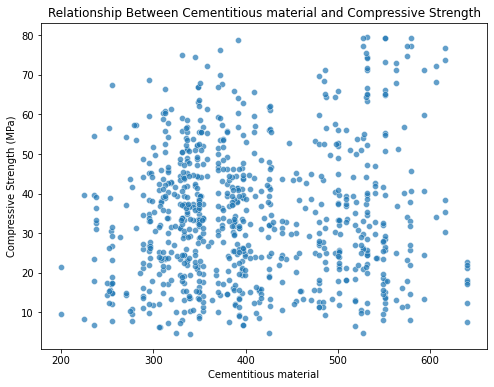

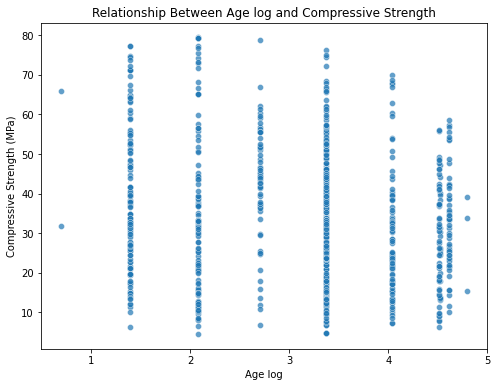

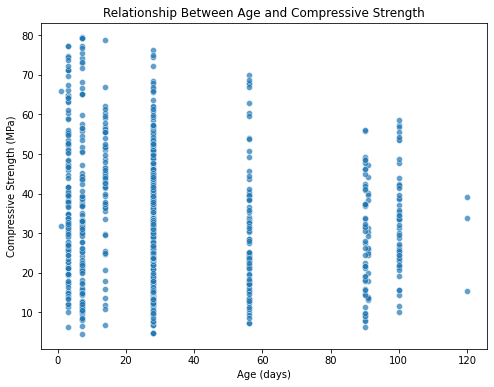

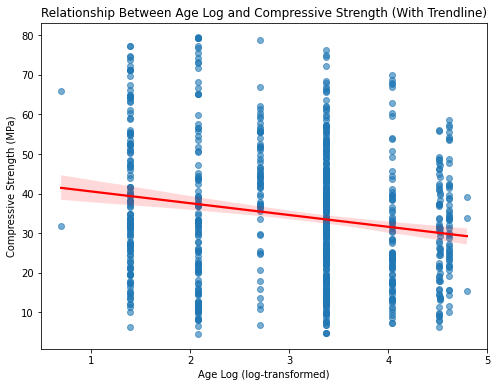

In [44]:

scaled_data["water_to_cement_ratio"] = df["water"] / df["cement"]
scaled_data["aggregate_ratio"] = df["coarse_aggregate"] / (
    df["coarse_aggregate"] + df["fine_aggregate"]
)
scaled_data["cementitious_material"] = df["cement"] + df["slag"] + df["fly_ash"]
scaled_data["age_log"] = np.log1p(df["age"])

print(scaled_data.columns)

new_features = [
    "water_to_cement_ratio",
    "aggregate_ratio",
    "cementitious_material",
    "age_log",
]
for feature in new_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=scaled_data[feature], y=scaled_data[target_column], alpha=0.7)
    plt.title(
        f"Relationship Between {feature.replace('_', ' ').capitalize()} and Compressive Strength"
    )
    plt.xlabel(feature.replace("_", " ").capitalize())
    plt.ylabel("Compressive Strength (MPa)")
    plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["age"], y=scaled_data[target_column], alpha=0.7)
plt.title("Relationship Between Age and Compressive Strength")
plt.xlabel("Age (days)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(
    x="age_log",
    y=scaled_data[target_column],
    data=scaled_data,
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"},
)
plt.title("Relationship Between Age Log and Compressive Strength (With Trendline)")
plt.xlabel("Age Log (log-transformed)")
plt.ylabel("Compressive Strength (MPa)")
plt.show()

C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


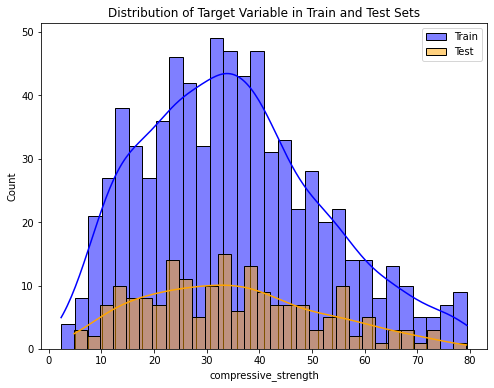

In [45]:
X = scaled_data.drop(target_column, axis=1)
y = scaled_data[target_column]

def stratified_split(X, y, test_size=0.2, random_state=42):
    y_binned, bins = pd.qcut(y, q=10, retbins=True, duplicates="drop")
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y_binned
    )


X_train, X_test, y_train, y_test = stratified_split(X, y)

plt.figure(figsize=(8, 6))
sns.histplot(y_train, kde=True, bins=30, color="blue", label="Train")
sns.histplot(y_test, kde=True, bins=30, color="orange", label="Test")
plt.title("Distribution of Target Variable in Train and Test Sets")
plt.legend()
plt.show()

### Model Development


In [46]:
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Linear Regression MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")

Linear Regression MAE: 6.037781834318119
Linear Regression RMSE: 7.812648731334694


In [47]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")

Random Forest MAE: 3.917083713885926
Random Forest RMSE: 5.543897692029436


In [48]:
param_grid = {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20, 30]}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best parameters: {'max_depth': None, 'n_estimators': 300}


### Model Validation and Comparison


In [49]:
y_pred_best = best_rf.predict(X_test)
print(f"BETTER Random Forest MAE: {mean_absolute_error(y_test, y_pred_best)}")
print(
    f"BETTER Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best))}"
)

BETTER Random Forest MAE: 3.838871409873061
BETTER Random Forest RMSE: 5.477873484307733


In [50]:
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

feature_names = X.columns
importance = rf.feature_importances_
best_features = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print("\nThings Impacting Compressive Strength the Most:")
for feature, score in best_features:
    print(f"{feature}: {score:.4f}")
    
sample_data = scaled_data.copy()
sample_data[target_column] = rf.predict(X)

best_combinations = sample_data.sort_values(by=target_column, ascending=False).head(5)
print("\nBest Concrete Mix Combinations Predicted:")
print(best_combinations)


Things Impacting Compressive Strength the Most:
age: 0.3205
cement: 0.2981
superplasticizer: 0.0954
water: 0.0925
slag: 0.0875
fine_aggregate: 0.0253
coarse_aggregate: 0.0211
fly_ash: 0.0169
cementitious_material: 0.0137
water_to_cement_ratio: 0.0118
aggregate_ratio: 0.0108
age_log: 0.0063

Best Concrete Mix Combinations Predicted:
       cement      slag   fly_ash     water  superplasticizer  \
113  0.871499  1.340014 -0.915228 -0.835834          0.987316   
109  0.871499  1.340014 -0.915228 -0.835834          0.987316   
111  0.871499  1.340014 -0.915228 -0.835834          0.987316   
115  0.871499  1.340014 -0.915228 -0.835834          0.987316   
94   0.871499  1.340014 -0.915228 -0.835834          0.987316   

     coarse_aggregate  fine_aggregate       age  compressive_strength  \
113         -0.394696       -0.329621  2.069726             78.779804   
109         -0.394696       -0.329621  2.069726             78.719819   
111         -0.394696       -0.329621  2.069726        

C:\Users\Joe's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### Optimization


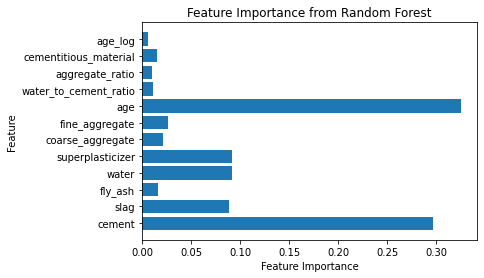

In [51]:
importances = best_rf.feature_importances_
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.show()